# Credit card default prediction

Dataset src: <https://www.kaggle.com/datasets/pratjain/credit-card-default>

Other resources:

- Dealing with imbalanced target vars: <https://medium.com/@mmalinda/testing-recommendations-for-binary-classification-with-an-imbalanced-target-variable-ff8b120ea8c9>

In [71]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [34]:
df = pd.read_csv("credit_card_default_TRAIN.csv", skiprows=1)

## Data preparation

In [35]:
# data size overview

print(f"# of samples: {len(df)}")
print(f"# of features: {len(df.columns)}")

# of samples: 22500
# of features: 25


In [36]:
# clean up feature names

df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head(2)

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [37]:
# inspect data types
# categorical features are encoded as numerics
# need to extract them manually

df.dtypes

id                            int64
limit_bal                     int64
sex                           int64
education                     int64
marriage                      int64
age                           int64
pay_0                         int64
pay_2                         int64
pay_3                         int64
pay_4                         int64
pay_5                         int64
pay_6                         int64
bill_amt1                     int64
bill_amt2                     int64
bill_amt3                     int64
bill_amt4                     int64
bill_amt5                     int64
bill_amt6                     int64
pay_amt1                      int64
pay_amt2                      int64
pay_amt3                      int64
pay_amt4                      int64
pay_amt5                      int64
pay_amt6                      int64
default_payment_next_month    int64
dtype: object

In [38]:
# extract categorical features
# need to drill down into pay_i categories

feature_map = {col: df[col].nunique() for col in list(df.columns)}
pprint.pprint(feature_map)

{'age': 55,
 'bill_amt1': 17712,
 'bill_amt2': 17398,
 'bill_amt3': 17152,
 'bill_amt4': 16769,
 'bill_amt5': 16359,
 'bill_amt6': 15972,
 'default_payment_next_month': 2,
 'education': 7,
 'id': 22500,
 'limit_bal': 77,
 'marriage': 4,
 'pay_0': 11,
 'pay_2': 11,
 'pay_3': 11,
 'pay_4': 11,
 'pay_5': 10,
 'pay_6': 10,
 'pay_amt1': 6592,
 'pay_amt2': 6476,
 'pay_amt3': 6050,
 'pay_amt4': 5732,
 'pay_amt5': 5674,
 'pay_amt6': 5684,
 'sex': 2}


In [39]:
# pay_i denotes payment status for month i (i=0,2,3,...,6) where i=0 is 09/2005 and i=6 is 04/2005
# pay_i = -1 means pay duly
# pay_i = 0 means revolving credit
# pay_i = 1 means payment delay for two months
# pay_i = 2 means payment delay for three months
# pay_i = -2 means no consumption for the month
# and so on

df["pay_0"].value_counts()

pay_0
 0    11069
-1     4322
 1     2830
 2     2093
-2     1830
 3      243
 4       63
 8       17
 5       17
 6        9
 7        7
Name: count, dtype: int64

In [40]:
# set cols for reuse

categorical_features = [
    "education", "marriage", "pay_0", "pay_2", "pay_3", "pay_4", "pay_5", "pay_6", "sex"
]

numerical_features = [
    col for col in df.columns if col not in categorical_features and col != "id" and col != "default_payment_next_month"
]

In [41]:
# drop id column

df.drop("id", axis=1, inplace=True)

In [42]:
# inspect nans

df.isnull().sum() # nothing to do here fortunately

limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64

In [43]:
# the target variable is imbalanced
# consider other methods - ensemble, boosting, forests, bagging, etc.

# some recommendations:
# https://medium.com/@mmalinda/testing-recommendations-for-binary-classification-with-an-imbalanced-target-variable-ff8b120ea8c9

df["default_payment_next_month"].value_counts(normalize=True)

default_payment_next_month
0    0.773867
1    0.226133
Name: proportion, dtype: float64

## Validation framework

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [46]:
print(len(df_train), len(df_val), len(df_test))

13500 4500 4500


In [47]:
y_train = df_train["default_payment_next_month"].values
y_val = df_val["default_payment_next_month"].values
y_test = df_test["default_payment_next_month"].values

del df_train["default_payment_next_month"]
del df_val["default_payment_next_month"]
del df_test["default_payment_next_month"]

## EDA

In [48]:
eda = df_full_train.copy()

In [49]:
eda.head(1)

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
8586,170000,2,1,1,63,0,0,0,0,0,...,59560,61442,63422,3000,2500,2500,3000,3000,2651,0


In [50]:
eda.sex.value_counts(normalize=True)

sex
2    0.6075
1    0.3925
Name: proportion, dtype: float64

In [51]:
# sex is not very predictive

eda.groupby(["sex"]).default_payment_next_month.mean()

sex
1    0.245435
2    0.210608
Name: default_payment_next_month, dtype: float64

In [73]:
# education is predictive

eda.groupby(["education"]).default_payment_next_month.mean()

education
0    0.000000
1    0.192966
2    0.240174
3    0.259053
4    0.052632
5    0.075862
6    0.120000
Name: default_payment_next_month, dtype: float64

In [74]:
# marital status is not very predictive

eda.groupby(["marriage"]).default_payment_next_month.mean()

marriage
0    0.032258
1    0.240189
2    0.210910
3    0.264423
Name: default_payment_next_month, dtype: float64

In [52]:
eda.education.value_counts(normalize=True)

education
2    0.473500
1    0.353833
3    0.159556
5    0.008056
4    0.003167
6    0.001389
0    0.000500
Name: proportion, dtype: float64

In [53]:
# education has some predictive value

eda.groupby(["education"]).default_payment_next_month.mean()

education
0    0.000000
1    0.192966
2    0.240174
3    0.259053
4    0.052632
5    0.075862
6    0.120000
Name: default_payment_next_month, dtype: float64

In [54]:
# use synthetic approach and calculate mutual information / entropy for each categorical feature

from sklearn.metrics import mutual_info_score

def calculate_mi(series):
    return mutual_info_score(series, df_full_train.default_payment_next_month)

mi = eda[categorical_features].apply(calculate_mi)
mi = mi.sort_values(ascending=False)

mi

pay_0        0.076982
pay_2        0.049405
pay_3        0.037636
pay_4        0.032250
pay_5        0.031638
pay_6        0.026163
education    0.003083
marriage     0.000913
sex          0.000825
dtype: float64

In [55]:
# calculate correlation for numerical features

eda[numerical_features].corrwith(eda.default_payment_next_month).abs().sort_values(ascending=False)

limit_bal    0.144338
pay_amt1     0.074535
pay_amt2     0.056004
pay_amt4     0.054297
pay_amt6     0.054103
pay_amt3     0.054061
pay_amt5     0.048757
bill_amt1    0.024862
age          0.018236
bill_amt2    0.017842
bill_amt3    0.016042
bill_amt4    0.007900
bill_amt5    0.003639
bill_amt6    0.000925
dtype: float64

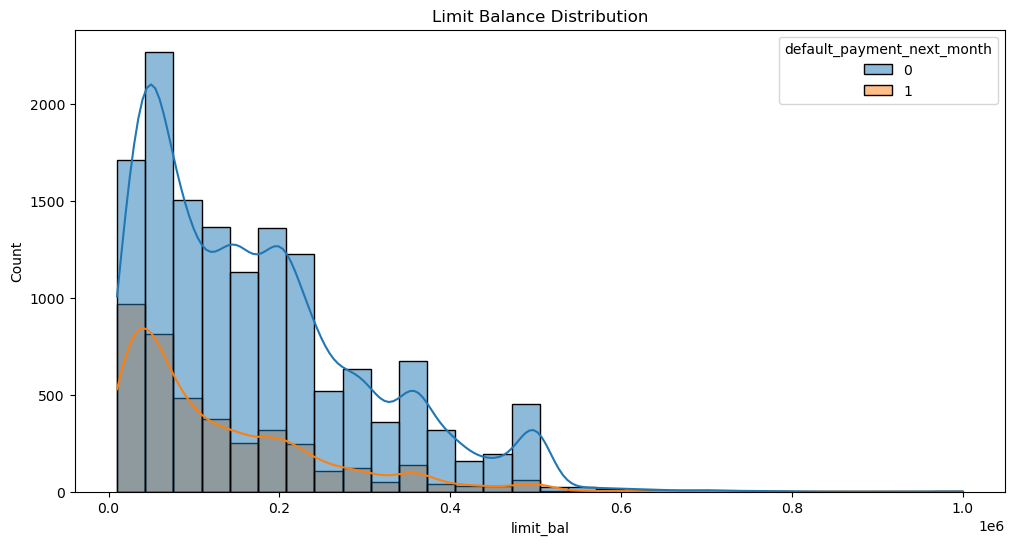

In [56]:
# visualize distributions of highly correlated numerical features - limit_bal vs target

plt.figure(figsize=(12, 6))

p = sns.histplot(eda, x="limit_bal", hue="default_payment_next_month", kde=True, bins=30).set(title="Limit Balance Distribution")

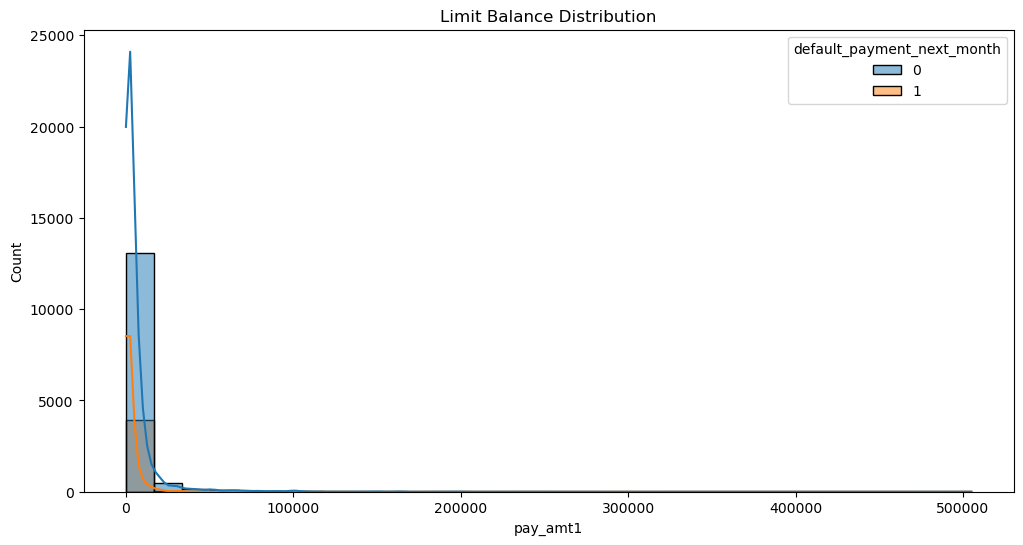

In [57]:
# visualize distributions of numerical features - pay_amt1 vs target
# significant outliers!

plt.figure(figsize=(12, 6))

p = sns.histplot(eda, x="pay_amt1", hue="default_payment_next_month", kde=True, bins=30).set(title="Limit Balance Distribution")

In [59]:
# would make sense to log transform or clip this
# need to establish the best approach

eda.pay_amt1.describe() 

count     18000.000000
mean       5528.951500
std       15475.094196
min           0.000000
25%        1000.000000
50%        2100.000000
75%        5000.000000
max      505000.000000
Name: pay_amt1, dtype: float64

interquartile range: 4000.0
lower bound: -5000.0
upper bound: 11000.0
# of outliers: 1622
% of outliers: 9.011111111111111
mean outlier: 33983.835388409374


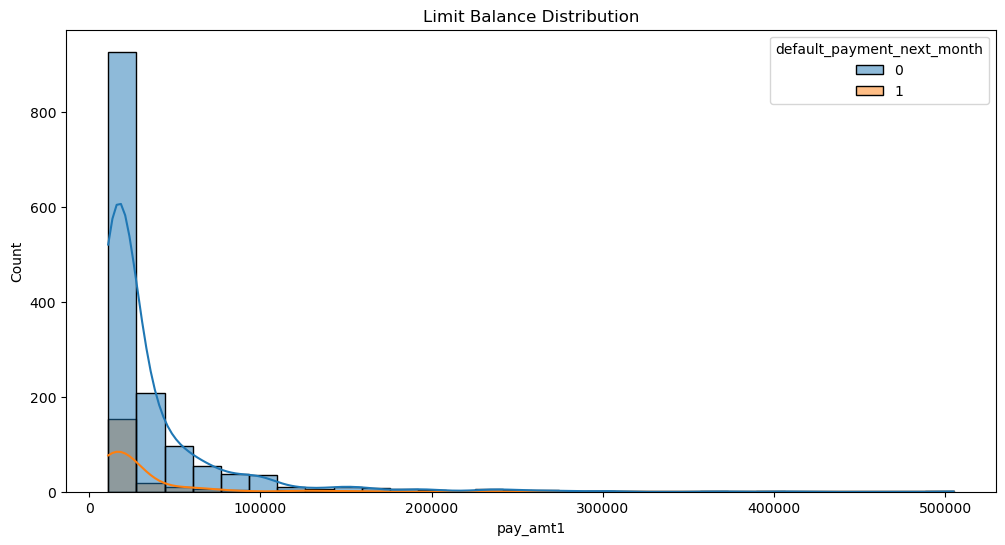

In [67]:
# need to look closer at distribution tails

iqr = eda.pay_amt1.quantile(0.75) - eda.pay_amt1.quantile(0.25)
print(f"interquartile range: {iqr}")

lower_bound = eda.pay_amt1.quantile(0.25) - 1.5 * iqr
upper_bound = eda.pay_amt1.quantile(0.75) + 1.5 * iqr
print(f"lower bound: {lower_bound}") # clip at 0 because <0 doesn't make sense
print(f"upper bound: {upper_bound}") # verify how many values are above this threshold

outliers = eda[eda.pay_amt1 > upper_bound]
print(f"# of outliers: {len(outliers)}")
print(f"% of outliers: {len(outliers) / len(eda) * 100}") # pretty significant!

# let's check the distribution of outliers themselves - mostly their mean

print(f"mean outlier: {outliers.pay_amt1.mean()}")

# graph the distribution of outliers

plt.figure(figsize=(12, 6))

p = sns.histplot(outliers, x="pay_amt1", hue="default_payment_next_month", kde=True, bins=30).set(title="Limit Balance Distribution")

Text(0.5, 1.0, 'pay_amt3')

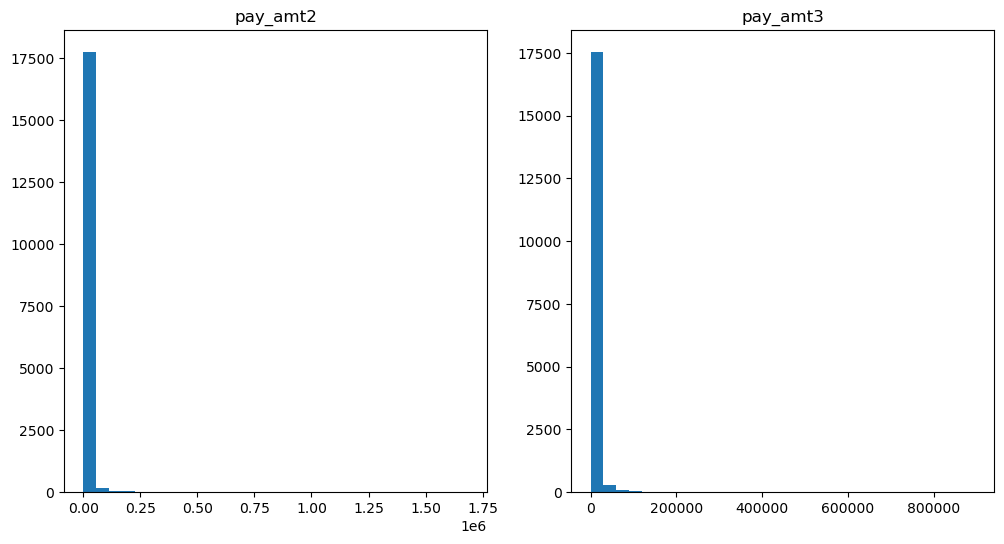

In [70]:
# inspect the rest of pay_amt features in similar fashion

f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(eda.pay_amt2, bins=30)
ax[0].set_title("pay_amt2")
ax[1].hist(eda.pay_amt3, bins=30)
ax[1].set_title("pay_amt3")

In [72]:
# all pay_amt features have significant outliers and should be log transformed

df_train.pay_amt1 = np.log1p(df_train.pay_amt1)
df_val.pay_amt1 = np.log1p(df_val.pay_amt1)
df_test.pay_amt1 = np.log1p(df_test.pay_amt1)

df_train.pay_amt2 = np.log1p(df_train.pay_amt2)
df_val.pay_amt2 = np.log1p(df_val.pay_amt2)
df_test.pay_amt2 = np.log1p(df_test.pay_amt2)

df_train.pay_amt3 = np.log1p(df_train.pay_amt3)
df_val.pay_amt3 = np.log1p(df_val.pay_amt3)
df_test.pay_amt3 = np.log1p(df_test.pay_amt3)

df_train.pay_amt4 = np.log1p(df_train.pay_amt4)
df_val.pay_amt4 = np.log1p(df_val.pay_amt4)
df_test.pay_amt4 = np.log1p(df_test.pay_amt4)

df_train.pay_amt5 = np.log1p(df_train.pay_amt5)
df_val.pay_amt5 = np.log1p(df_val.pay_amt5)
df_test.pay_amt5 = np.log1p(df_test.pay_amt5)

df_train.pay_amt6 = np.log1p(df_train.pay_amt6)
df_val.pay_amt6 = np.log1p(df_val.pay_amt6)
df_test.pay_amt6 = np.log1p(df_test.pay_amt6)

## One hot encoding

In [75]:
from sklearn.feature_extraction import DictVectorizer

In [83]:
# one way to mark categorical features as such is to convert them to strings

df_train[categorical_features] = df_train[categorical_features].astype(str)
df_val[categorical_features] = df_val[categorical_features].astype(str)
df_test[categorical_features] = df_test[categorical_features].astype(str)

In [84]:
dv = DictVectorizer(sparse=False)

In [85]:
dicts = df_train[categorical_features + numerical_features].to_dict(orient="records")
dv.fit(dicts)

DictVectorizer(sparse=False)

In [86]:
dv.get_feature_names_out()

array(['age', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4',
       'bill_amt5', 'bill_amt6', 'education=0', 'education=1',
       'education=2', 'education=3', 'education=4', 'education=5',
       'education=6', 'limit_bal', 'marriage=0', 'marriage=1',
       'marriage=2', 'marriage=3', 'pay_0=-1', 'pay_0=-2', 'pay_0=0',
       'pay_0=1', 'pay_0=2', 'pay_0=3', 'pay_0=4', 'pay_0=5', 'pay_0=6',
       'pay_0=7', 'pay_0=8', 'pay_2=-1', 'pay_2=-2', 'pay_2=0', 'pay_2=1',
       'pay_2=2', 'pay_2=3', 'pay_2=4', 'pay_2=5', 'pay_2=6', 'pay_2=7',
       'pay_2=8', 'pay_3=-1', 'pay_3=-2', 'pay_3=0', 'pay_3=1', 'pay_3=2',
       'pay_3=3', 'pay_3=4', 'pay_3=5', 'pay_3=6', 'pay_3=7', 'pay_3=8',
       'pay_4=-1', 'pay_4=-2', 'pay_4=0', 'pay_4=1', 'pay_4=2', 'pay_4=3',
       'pay_4=4', 'pay_4=5', 'pay_4=6', 'pay_4=7', 'pay_4=8', 'pay_5=-1',
       'pay_5=-2', 'pay_5=0', 'pay_5=2', 'pay_5=3', 'pay_5=4', 'pay_5=5',
       'pay_5=6', 'pay_5=7', 'pay_5=8', 'pay_6=-1', 'pay_6=-2', 'pay_6=0',
    

In [88]:
X_train = dv.transform(dicts)
X_val = dv.transform(df_val[categorical_features + numerical_features].to_dict(orient="records"))
X_test = dv.transform(df_test[categorical_features + numerical_features].to_dict(orient="records"))

In [92]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(13500, 91)
(4500, 91)
(4500, 91)


## Model test iteration

In [93]:
from sklearn.linear_model import LogisticRegression

In [95]:
model = LogisticRegression(max_iter=20_000) # brute force!
model.fit(X_train, y_train)

/Users/piotrswiecik/miniconda3/envs/mlz/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=20000)

In [96]:
model.coef_[0].round(3)

array([ 0.003,  0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   , -0.003,
        0.001,  0.059,  0.006, -0.012, -0.03 , -0.003, -0.   , -0.01 ,
        0.105, -0.074, -0.004, -0.131, -0.145, -0.614, -0.041,  0.811,
        0.122,  0.012, -0.001,  0.001,  0.004,  0.001, -0.152, -0.121,
       -0.184, -0.005,  0.435,  0.035, -0.002,  0.005,  0.006,  0.001,
       -0.001, -0.12 , -0.196, -0.056, -0.   ,  0.333,  0.025,  0.011,
        0.003,  0.003,  0.012,  0.001, -0.106, -0.205, -0.005, -0.   ,
        0.27 ,  0.033,  0.017, -0.005,  0.   ,  0.018, -0.   , -0.109,
       -0.198, -0.034,  0.289,  0.039,  0.004,  0.003,  0.   ,  0.021,
        0.001, -0.072, -0.203, -0.06 ,  0.276,  0.042,  0.004,  0.002,
        0.011,  0.015,  0.002, -0.044, -0.01 , -0.047, -0.021, -0.022,
       -0.014,  0.086, -0.069])

In [97]:
model.intercept_[0].round(3)

np.float64(0.017)

In [98]:
# default probs on eval set

y_pred = model.predict_proba(X_val)[:, 1]

<Axes: ylabel='Count'>

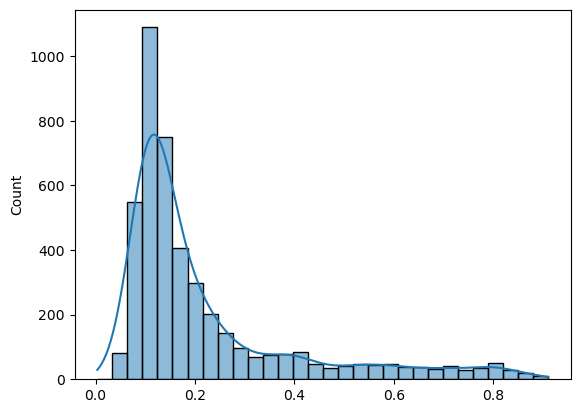

In [100]:
sns.histplot(y_pred, bins=30, kde=True)

In [101]:
cutoff = 0.5

y_pred = (y_pred > cutoff).astype(int)

In [103]:
y_pred.mean() # predicted default rate on val set is way lower than on training

np.float64(0.10577777777777778)

In [105]:
# accuracy score

acc = (y_val == y_pred).mean()
acc # acc is not too bad though

np.float64(0.804)

In [106]:
# confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)
cm

# true negatives, false positives, false negatives, true positives

array([[3314,  172],
       [ 710,  304]])

In [107]:
# precision, recall, f1-score

from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

# conlusion
# plenty of false negatives - maybe the cutoff is too high?
# only 30% of defaults are being caught

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3486
           1       0.64      0.30      0.41      1014

    accuracy                           0.80      4500
   macro avg       0.73      0.63      0.65      4500
weighted avg       0.78      0.80      0.78      4500



## Model improvement strategies

1. Tune cutoff threshold using precision-recall curve
2. Handle imbalance by using class weight parameter
3. Consider oversampling or undersampling
4. Try regularization